### Install or import dependencies

In [11]:
### From: https://colab.research.google.com/drive/1VWoGcpyqGvrUOUzH7ccppE__m-n1cAiI?usp=sharing#scrollTo=x10crvpWAnog
!pip3 install --quiet -U ncps pytorch-lightning

In [12]:
### From: https://colab.research.google.com/drive/1VWoGcpyqGvrUOUzH7ccppE__m-n1cAiI?usp=sharing#scrollTo=x10crvpWAnog
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC, CfC
import pytorch_lightning as pl
import torch
import torch.utils.data as data

In [13]:
try:
    import torchdiffeq
except ModuleNotFoundError:
    !pip install --quiet torchdiffeq
    import torchdiffeq
import numpy as np
import torch
import torch.nn as nn
import torchdiffeq as diff
from torchdiffeq import odeint
import csv
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, ExponentialLR
import time
import random
import os
import logging
import matplotlib.pyplot as plt

print(torchdiffeq.__version__)

0.2.3


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# # Read data
# filename = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=1_sumSteps=200.csv"

# with open(filename, 'r') as csvfile:
#     trajs = torch.tensor([[float(value) for value in row] for row in csv.reader(csvfile)])

In [16]:
# # define function to round down to nearest number
# def rounddown(x, number):
#   '''Rounds down to the nearest multiple of number specified'''
#   return int(x // number) * number

# # split data into training, validation, and testing
# # trajectories are randomly initiated, so there is no need to further randomize

# rows = trajs.shape[0]
# train_split = 0.7*0.1202 # Use portion of dataset
# val_split = 0.15*0.1202

# train_stop = rounddown(rows*train_split, 200)
# val_stop = train_stop + rounddown(rows*val_split, 200)

# train_data = trajs[:train_stop,:]
# val_data = trajs[train_stop:val_stop,:]
# test_data = trajs[val_stop:,:]

train_file = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=1_sumSteps=200_TRAIN.csv"
val_file = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=1_sumSteps=200_VAL.csv"
test_file = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=1_sumSteps=200_TEST.csv"

# np.savetxt(train_file, train_data, delimiter=",")
# np.savetxt(val_file, val_data, delimiter=",")
# np.savetxt(test_file, test_data, delimiter=",")

In [17]:
# Dataset for evaluation
class CustomDatasetLTC(Dataset):
    def __init__(self, filename, device, num_gpus, num_steps = 200): # can take as input files
        with open(filename, 'r') as csvfile:
          reader = csv.reader(csvfile)
          self.trajs = torch.tensor([[float(value) for value in row] for i,row in enumerate(reader)])

        self.num_steps = num_steps

    def __getitem__(self, idx):

        start_index = self.num_steps*idx
        end_index = start_index + self.num_steps

        input_ic = self.trajs[start_index,4:] # take initial condition
        input_pad = torch.zeros([self.num_steps-1, 12]) # pad with zeros

        input = torch.cat([input_ic.unsqueeze(0), input_pad], dim = 0)
        label = self.trajs[start_index:end_index,4:] # take whole trajectory as label

        return input, label

    def __len__(self): # return length of dataset
        if len(self.trajs) % self.num_steps != 0:
            raise ValueError("Total number of rows in the dataset is not divisible by num_steps")

        length = len(self.trajs)//self.num_steps
        return length

In [18]:
### From https://colab.research.google.com/drive/1VWoGcpyqGvrUOUzH7ccppE__m-n1cAiI?usp=sharing#scrollTo=x10crvpWAnog

# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [ ]:
class LTC_FC(nn.Module):
    def __init__(self, input_size, LTC_input_size, batch_first):
        super(NeuralODE, self).__init__()

        self.inflate = nn.Sequential(
            nn.Linear(input_size, LTC_input_size),
            nn.ReLU()
            )

        self.LTC = LTC(input_size=LTC_input_size, return_sequences=False, \
                       units=LTC_input_size, batch_first=batch_first)

        # Define the forward pass of the network
        self.deflate = nn.Linear(LTC_input_size, input_size)

    def forward(self, t, state):

        # output represents the derivative of the state
        state = self.inflate(state)
        state, _ = self.LTC(state)
        state_dot = self.deflate(state)

        return state_dot

In [19]:
def main():

    # Define Hyperparameters
    EPOCHS = 400
    EPOCHS_PER_SAVE = 10
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-2
    VERSION = "LTC_G1_itr7"
    VERSION_SUBFOLDER = ""  # e.g. "MNIST/" or ""

    # Define the loss file paths
    train_loss_file = f"/content/drive/MyDrive/EC523 Final Project/Results/train_losses_{VERSION}.txt"
    val_loss_file = f"/content/drive/MyDrive/EC523 Final Project/Results/val_losses_{VERSION}.txt"

    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Initialize device, model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_gpus = torch.cuda.device_count()

    # Define dataloaders
    train_dataset = CustomDatasetLTC(filename=train_file, num_steps=200, device=device, num_gpus=num_gpus)
    val_dataset = CustomDatasetLTC(filename=val_file, num_steps=200, device=device, num_gpus=num_gpus)

    # Instantiate data loaders, optimizer, criterion
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                                  shuffle=False, drop_last=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, \
                                shuffle=False, drop_last=True, num_workers=2)

    # Initialize lists to store losses during training
    train_losses = []
    val_losses = []

    # Define a callback to log losses during training
    class LossLoggingCallback(pl.Callback):
        def on_train_epoch_end(self, trainer, pl_module):
            train_loss = trainer.callback_metrics['train_loss'].item()
            val_loss = trainer.callback_metrics['val_loss'].item()

            # Log losses to file
            with open(train_loss_file, 'a') as file:
                file.write(f"{train_loss}\n")
            with open(val_loss_file, 'a') as file:
                file.write(f"{val_loss}\n")

            # Append losses to the lists
            train_losses.append(train_loss)
            val_losses.append(val_loss)

    # give file path to save model
    model_path = f"/content/drive/MyDrive/EC523 Final Project/Results/modelsaves/{VERSION}/"
    os.makedirs(model_path, exist_ok=True)

    #############################################################################################
    ### Begin modified from https://ncps.readthedocs.io/en/latest/examples/torch_first_steps.html

    out_features = 12
    in_features = 12

    wiring = AutoNCP(128, out_features)  # 512 units, 12 motor neurons representing output

    ltc_model = LTC(input_size=in_features, return_sequences=True, units=wiring, batch_first=True)

    learn = SequenceLearner(ltc_model, lr=LEARNING_RATE)

    trainer = pl.Trainer(
        accelerator="gpu",
        logger=pl.loggers.CSVLogger("log"),
        max_epochs=EPOCHS,
        gradient_clip_val=1,
        callbacks=[pl.callbacks.EarlyStopping(monitor='val_loss'), \
                   LossLoggingCallback(), \
                   pl.callbacks.ModelCheckpoint(dirpath=model_path, \
                                                every_n_epochs=EPOCHS_PER_SAVE)],
        default_root_dir="/content/drive/MyDrive/EC523 Final Project/Results",
    )

    trainer.fit(learn, train_dataloader, val_dataloader)

    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/EC523 Final Project/Results/loss_curves_{VERSION}.png")
    plt.show()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 1.5 K 
-------------------------------
1.2 K     Trainable params
288       Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


alloc!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

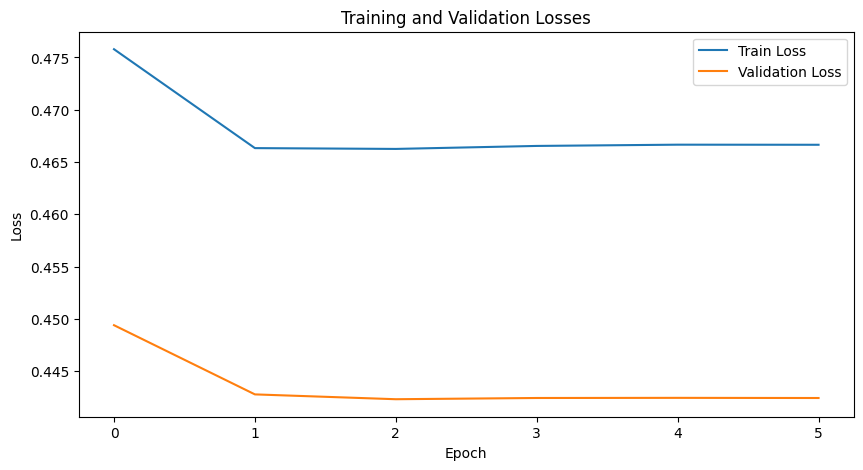

In [20]:
main()